DATA PIPELINE

In [1]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input, Dropout, Conv2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import regularizers
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [2]:
test_data = pd.read_csv("./Fashion-MNIST/fashion-mnist_test.csv",sep = ',' , header =0 , index_col = None
            , dtype = int )
train_data = pd.read_csv("./Fashion-MNIST/fashion-mnist_train.csv",sep = ',' , header =0 , index_col = None
            , dtype = int )

In [3]:
X_raw = train_data.drop('label', axis=1).values / 255.0
Y_raw = train_data['label'].values

# Split into training and validation (80/20)
X_train, X_val, Y_train, Y_val = train_test_split(X_raw, Y_raw, test_size=0.2, random_state=42)

# Reshape into (n, 28, 28, 1)
X_train = X_train.reshape(-1, 28, 28, 1)
X_val = X_val.reshape(-1, 28, 28, 1)

# Data augmentation
def augment(image, label):
    """Apply random augmentations to training images."""
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, max_delta=0.1)
    return image, label

# Preprocessing
def preprocess(image, label):
    """Resize image to 224x224 and convert label to one-hot."""
    image = tf.image.resize(image, [224, 224])  # Keep 1-channel (grayscale)
    label = tf.one_hot(label, depth=10)  # Convert to one-hot for 10 classes
    return image, label

# Create datasets
BATCH_SIZE = 32
train_ds = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
train_ds = train_ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.map(augment, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.cache().shuffle(1000).batch(BATCH_SIZE, drop_remainder=True).prefetch(tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((X_val, Y_val))
val_ds = val_ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.cache().batch(BATCH_SIZE, drop_remainder=True).prefetch(tf.data.AUTOTUNE)

2025-05-25 02:43:12.087415: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3
2025-05-25 02:43:12.087615: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-05-25 02:43:12.087635: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2025-05-25 02:43:12.087987: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-05-25 02:43:12.088010: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


MODEL

In [4]:

# Verify dataset shapes
for images, labels in train_ds.take(1):
    print(f"Image batch shape: {images.shape}, Label batch shape: {labels.shape}")
    assert images.shape == (BATCH_SIZE, 224, 224, 1), "Incorrect image shape (expected 1 channel)"
    assert labels.shape == (BATCH_SIZE, 10), "Incorrect label shape (expected one-hot)"


Image batch shape: (32, 224, 224, 1), Label batch shape: (32, 10)


2025-05-25 02:43:12.501160: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2025-05-25 02:43:12.507932: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [5]:
# Model: Initial Training
model_input = Input(shape=(224, 224, 1), name='input_layer')
x = Conv2D(3, (1, 1), activation='linear', trainable=True, name='channel_adapter')(model_input)
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

x = base_model(x, training=False)
x = GlobalAveragePooling2D(name='global_avg_pool')(x)
x = Dropout(0.5, name='dropout_head')(x)
x = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001), name='dense_head')(x)
output = Dense(10, activation='softmax', dtype='float32', name='output')(x)

model = Model(inputs=model_input, outputs=output)

# Compile model
model.compile(
    optimizer=Adam(1e-4),
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.TopKCategoricalAccuracy(k=1, name='top_1_accuracy')
    ]
)

# Callbacks
checkpoint = ModelCheckpoint('best_model_head.h5', monitor='val_accuracy', save_best_only=True, mode='max')
early_stop = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)

In [6]:
# Train head
print("Training head...")
history_head = model.fit(train_ds, validation_data=val_ds, epochs=5, callbacks=[checkpoint, early_stop])


Training head...
Epoch 1/5


2025-05-25 02:43:13.989387: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2025-05-25 02:43:13.992474: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step - accuracy: 0.5688 - loss: 1.4771 - precision: 0.7517 - recall: 0.4172 - top_1_accuracy: 0.5688

2025-05-25 02:49:34.500135: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 433s 287ms/step - accuracy: 0.5689 - loss: 1.4768 - precision: 0.7517 - recall: 0.4174 - top_1_accuracy: 0.5689 - val_accuracy: 0.8262 - val_loss: 0.6847 - val_precision: 0.8708 - val_recall: 0.7830 - val_top_1_accuracy: 0.8262
Epoch 2/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step - accuracy: 0.7972 - loss: 0.7658 - precision: 0.8475 - recall: 0.7460 - top_1_accuracy: 0.7972

1500/1500 ━━━━━━━━━━━━━━━━━━━━ 456s 304ms/step - accuracy: 0.7972 - loss: 0.7658 - precision: 0.8475 - recall: 0.7460 - top_1_accuracy: 0.7972 - val_accuracy: 0.8471 - val_loss: 0.6034 - val_precision: 0.8825 - val_recall: 0.8107 - val_top_1_accuracy: 0.8471
Epoch 3/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step - accuracy: 0.8181 - loss: 0.6886 - precision: 0.8590 - recall: 0.7745 - top_1_accuracy: 0.8181

1500/1500 ━━━━━━━━━━━━━━━━━━━━ 442s 295ms/step - accuracy: 0.8181 - loss: 0.6886 - precision: 0.8590 - recall: 0.7745 - top_1_accuracy: 0.8181 - val_accuracy: 0.8512 - val_loss: 0.5627 - val_precision: 0.8859 - val_recall: 0.8190 - val_top_1_accuracy: 0.8512
Epoch 4/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step - accuracy: 0.8245 - loss: 0.6434 - precision: 0.8661 - recall: 0.7824 - top_1_accuracy: 0.8245

1500/1500 ━━━━━━━━━━━━━━━━━━━━ 416s 277ms/step - accuracy: 0.8245 - loss: 0.6434 - precision: 0.8661 - recall: 0.7824 - top_1_accuracy: 0.8245 - val_accuracy: 0.8558 - val_loss: 0.5370 - val_precision: 0.8906 - val_recall: 0.8240 - val_top_1_accuracy: 0.8558
Epoch 5/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2108s 1s/step - accuracy: 0.8297 - loss: 0.6127 - precision: 0.8694 - recall: 0.7903 - top_1_accuracy: 0.8297 - val_accuracy: 0.8551 - val_loss: 0.5265 - val_precision: 0.8875 - val_recall: 0.8227 - val_top_1_accuracy: 0.8551


In [7]:
# Fine-Tuning Experiments
print("Preparing fine-tuning...")
base_model.trainable = True
for layer in base_model.layers[:-30]:
    layer.trainable = False

# Experiment configurations
dropout_rates = [0.3, 0.4, 0.5]
weight_decays = [0.0001, 0.001]
best_acc = 0
best_config = None
best_model_path = 'best_model_finetuned.h5'
fine_tune_histories = []

for dropout_rate in dropout_rates:
    for weight_decay in weight_decays:
        print(f"Experiment: Dropout={dropout_rate}, Weight Decay={weight_decay}")
        x = model_input
        x = Conv2D(3, (1, 1), activation='linear', trainable=True, 
                   name=f'channel_adapter_dr{dropout_rate}_wd{weight_decay}')(x)
        x = base_model(x, training=False)
        x = GlobalAveragePooling2D(name=f'global_avg_pool_dr{dropout_rate}_wd{weight_decay}')(x)
        x = Dropout(dropout_rate, name=f'dropout_dr{dropout_rate}_wd{weight_decay}')(x)
        x = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(weight_decay), 
                  name=f'dense_dr{dropout_rate}_wd{weight_decay}')(x)
        output = Dense(10, activation='softmax', dtype='float32', 
                       name=f'output_dr{dropout_rate}_wd{weight_decay}')(x)
        
        model = Model(inputs=model_input, outputs=output)
        model.compile(
            optimizer=Adam(1e-5),
            loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
            metrics=[
                'accuracy',
                tf.keras.metrics.Precision(name='precision'),
                tf.keras.metrics.Recall(name='recall'),
                tf.keras.metrics.TopKCategoricalAccuracy(k=1, name='top_1_accuracy')
            ]
        )
        
        checkpoint = ModelCheckpoint(f'model_dr{dropout_rate}_wd{weight_decay}.h5', 
                                    monitor='val_accuracy', save_best_only=True, mode='max')
        lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)
        
        try:
            history = model.fit(train_ds, validation_data=val_ds, epochs=5, 
                               callbacks=[checkpoint, early_stop, lr_scheduler])
            fine_tune_histories.append((history, dropout_rate, weight_decay))
        except Exception as e:
            print(f"Error during fine-tuning (Dropout={dropout_rate}, Weight Decay={weight_decay}): {e}")
            continue
        
        val_acc = max(history.history['val_accuracy'])
        if val_acc > best_acc:
            best_acc = val_acc
            best_config = (dropout_rate, weight_decay)
            try:
                model.save(best_model_path)
            except Exception as e:
                print(f"Error saving model: {e}")
# Load best fine-tuned model
if best_config is not None:
    print(f"Loading best model (Dropout={best_config[0]}, Weight Decay={best_config[1]})")
    try:
        model = tf.keras.models.load_model(best_model_path)
    except Exception as e:
        print(f"Error loading best model: {e}")
        raise
else:
    print("No fine-tuning experiments completed successfully; using head-trained model")



Preparing fine-tuning...
Experiment: Dropout=0.3, Weight Decay=0.0001
Epoch 1/5


2025-05-25 03:47:31.511995: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step - accuracy: 0.6008 - loss: 1.2259 - precision: 0.8330 - recall: 0.3846 - top_1_accuracy: 0.6008

2025-05-25 03:55:08.040369: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 514s 338ms/step - accuracy: 0.6008 - loss: 1.2256 - precision: 0.8331 - recall: 0.3847 - top_1_accuracy: 0.6008 - val_accuracy: 0.8203 - val_loss: 0.5067 - val_precision: 0.8649 - val_recall: 0.7780 - val_top_1_accuracy: 0.8203 - learning_rate: 1.0000e-05
Epoch 2/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step - accuracy: 0.8312 - loss: 0.4996 - precision: 0.8762 - recall: 0.7864 - top_1_accuracy: 0.8312

1500/1500 ━━━━━━━━━━━━━━━━━━━━ 523s 348ms/step - accuracy: 0.8312 - loss: 0.4995 - precision: 0.8762 - recall: 0.7864 - top_1_accuracy: 0.8312 - val_accuracy: 0.8683 - val_loss: 0.3864 - val_precision: 0.8958 - val_recall: 0.8423 - val_top_1_accuracy: 0.8683 - learning_rate: 1.0000e-05
Epoch 3/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step - accuracy: 0.8623 - loss: 0.4082 - precision: 0.8945 - recall: 0.8338 - top_1_accuracy: 0.8623

1500/1500 ━━━━━━━━━━━━━━━━━━━━ 526s 351ms/step - accuracy: 0.8623 - loss: 0.4082 - precision: 0.8945 - recall: 0.8339 - top_1_accuracy: 0.8623 - val_accuracy: 0.8840 - val_loss: 0.3440 - val_precision: 0.9066 - val_recall: 0.8642 - val_top_1_accuracy: 0.8840 - learning_rate: 1.0000e-05
Epoch 4/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step - accuracy: 0.8816 - loss: 0.3559 - precision: 0.9062 - recall: 0.8582 - top_1_accuracy: 0.8816

1500/1500 ━━━━━━━━━━━━━━━━━━━━ 512s 341ms/step - accuracy: 0.8816 - loss: 0.3559 - precision: 0.9062 - recall: 0.8582 - top_1_accuracy: 0.8816 - val_accuracy: 0.8935 - val_loss: 0.3219 - val_precision: 0.9108 - val_recall: 0.8771 - val_top_1_accuracy: 0.8935 - learning_rate: 1.0000e-05
Epoch 5/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step - accuracy: 0.8977 - loss: 0.3189 - precision: 0.9185 - recall: 0.8763 - top_1_accuracy: 0.8977

1500/1500 ━━━━━━━━━━━━━━━━━━━━ 513s 342ms/step - accuracy: 0.8977 - loss: 0.3189 - precision: 0.9185 - recall: 0.8763 - top_1_accuracy: 0.8977 - val_accuracy: 0.8997 - val_loss: 0.3061 - val_precision: 0.9155 - val_recall: 0.8838 - val_top_1_accuracy: 0.8997 - learning_rate: 1.0000e-05


Experiment: Dropout=0.3, Weight Decay=0.001
Epoch 1/5


2025-05-25 04:30:38.606182: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step - accuracy: 0.6809 - loss: 1.2181 - precision: 0.8521 - recall: 0.5090 - top_1_accuracy: 0.6809

2025-05-25 04:38:21.786023: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 518s 341ms/step - accuracy: 0.6809 - loss: 1.2178 - precision: 0.8521 - recall: 0.5091 - top_1_accuracy: 0.6809 - val_accuracy: 0.8831 - val_loss: 0.5551 - val_precision: 0.9048 - val_recall: 0.8597 - val_top_1_accuracy: 0.8831 - learning_rate: 1.0000e-05
Epoch 2/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step - accuracy: 0.8776 - loss: 0.5792 - precision: 0.9060 - recall: 0.8522 - top_1_accuracy: 0.8776

1500/1500 ━━━━━━━━━━━━━━━━━━━━ 779s 519ms/step - accuracy: 0.8776 - loss: 0.5792 - precision: 0.9060 - recall: 0.8522 - top_1_accuracy: 0.8776 - val_accuracy: 0.8968 - val_loss: 0.5147 - val_precision: 0.9135 - val_recall: 0.8828 - val_top_1_accuracy: 0.8968 - learning_rate: 1.0000e-05
Epoch 3/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8953 - loss: 0.5204 - precision: 0.9175 - recall: 0.8765 - top_1_accuracy: 0.8953

1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3735s 2s/step - accuracy: 0.8953 - loss: 0.5204 - precision: 0.9175 - recall: 0.8766 - top_1_accuracy: 0.8953 - val_accuracy: 0.9043 - val_loss: 0.4910 - val_precision: 0.9191 - val_recall: 0.8924 - val_top_1_accuracy: 0.9043 - learning_rate: 1.0000e-05
Epoch 4/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - accuracy: 0.9102 - loss: 0.4801 - precision: 0.9266 - recall: 0.8941 - top_1_accuracy: 0.9102

1500/1500 ━━━━━━━━━━━━━━━━━━━━ 441s 294ms/step - accuracy: 0.9102 - loss: 0.4801 - precision: 0.9266 - recall: 0.8941 - top_1_accuracy: 0.9102 - val_accuracy: 0.9080 - val_loss: 0.4792 - val_precision: 0.9219 - val_recall: 0.8975 - val_top_1_accuracy: 0.9080 - learning_rate: 1.0000e-05
Epoch 5/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step - accuracy: 0.9194 - loss: 0.4493 - precision: 0.9351 - recall: 0.9048 - top_1_accuracy: 0.9194

1500/1500 ━━━━━━━━━━━━━━━━━━━━ 462s 308ms/step - accuracy: 0.9194 - loss: 0.4493 - precision: 0.9351 - recall: 0.9048 - top_1_accuracy: 0.9194 - val_accuracy: 0.9098 - val_loss: 0.4727 - val_precision: 0.9210 - val_recall: 0.9010 - val_top_1_accuracy: 0.9098 - learning_rate: 1.0000e-05


Experiment: Dropout=0.4, Weight Decay=0.0001
Epoch 1/5


2025-05-25 06:09:33.721543: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step - accuracy: 0.6767 - loss: 1.0108 - precision: 0.8735 - recall: 0.4981 - top_1_accuracy: 0.6767

2025-05-25 06:16:46.338679: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 483s 317ms/step - accuracy: 0.6768 - loss: 1.0105 - precision: 0.8735 - recall: 0.4982 - top_1_accuracy: 0.6768 - val_accuracy: 0.8819 - val_loss: 0.3513 - val_precision: 0.9074 - val_recall: 0.8577 - val_top_1_accuracy: 0.8819 - learning_rate: 1.0000e-05
Epoch 2/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step - accuracy: 0.8767 - loss: 0.3741 - precision: 0.9052 - recall: 0.8500 - top_1_accuracy: 0.8767

1500/1500 ━━━━━━━━━━━━━━━━━━━━ 468s 312ms/step - accuracy: 0.8767 - loss: 0.3741 - precision: 0.9052 - recall: 0.8500 - top_1_accuracy: 0.8767 - val_accuracy: 0.8982 - val_loss: 0.3064 - val_precision: 0.9156 - val_recall: 0.8829 - val_top_1_accuracy: 0.8982 - learning_rate: 1.0000e-05
Epoch 3/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step - accuracy: 0.8951 - loss: 0.3251 - precision: 0.9162 - recall: 0.8744 - top_1_accuracy: 0.8951

1500/1500 ━━━━━━━━━━━━━━━━━━━━ 469s 313ms/step - accuracy: 0.8952 - loss: 0.3251 - precision: 0.9162 - recall: 0.8744 - top_1_accuracy: 0.8952 - val_accuracy: 0.9036 - val_loss: 0.2927 - val_precision: 0.9196 - val_recall: 0.8890 - val_top_1_accuracy: 0.9036 - learning_rate: 1.0000e-05
Epoch 4/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step - accuracy: 0.9033 - loss: 0.2925 - precision: 0.9219 - recall: 0.8872 - top_1_accuracy: 0.9033

1500/1500 ━━━━━━━━━━━━━━━━━━━━ 475s 316ms/step - accuracy: 0.9033 - loss: 0.2925 - precision: 0.9219 - recall: 0.8872 - top_1_accuracy: 0.9033 - val_accuracy: 0.9071 - val_loss: 0.2857 - val_precision: 0.9203 - val_recall: 0.8952 - val_top_1_accuracy: 0.9071 - learning_rate: 1.0000e-05
Epoch 5/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step - accuracy: 0.9107 - loss: 0.2699 - precision: 0.9272 - recall: 0.8970 - top_1_accuracy: 0.9107

1500/1500 ━━━━━━━━━━━━━━━━━━━━ 476s 318ms/step - accuracy: 0.9107 - loss: 0.2699 - precision: 0.9272 - recall: 0.8970 - top_1_accuracy: 0.9107 - val_accuracy: 0.9078 - val_loss: 0.2813 - val_precision: 0.9216 - val_recall: 0.8978 - val_top_1_accuracy: 0.9078 - learning_rate: 1.0000e-05
Experiment: Dropout=0.4, Weight Decay=0.001
Epoch 1/5


2025-05-25 06:49:06.972619: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 715ms/step - accuracy: 0.6661 - loss: 1.2707 - precision: 0.8455 - recall: 0.4910 - top_1_accuracy: 0.6661

2025-05-25 07:07:06.964479: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 1124s 743ms/step - accuracy: 0.6662 - loss: 1.2704 - precision: 0.8455 - recall: 0.4911 - top_1_accuracy: 0.6662 - val_accuracy: 0.8953 - val_loss: 0.5225 - val_precision: 0.9150 - val_recall: 0.8753 - val_top_1_accuracy: 0.8953 - learning_rate: 1.0000e-05
Epoch 2/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step - accuracy: 0.8896 - loss: 0.5476 - precision: 0.9149 - recall: 0.8661 - top_1_accuracy: 0.8896

1500/1500 ━━━━━━━━━━━━━━━━━━━━ 393s 262ms/step - accuracy: 0.8896 - loss: 0.5476 - precision: 0.9149 - recall: 0.8661 - top_1_accuracy: 0.8896 - val_accuracy: 0.9062 - val_loss: 0.4888 - val_precision: 0.9198 - val_recall: 0.8931 - val_top_1_accuracy: 0.9062 - learning_rate: 1.0000e-05
Epoch 3/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step - accuracy: 0.9029 - loss: 0.4981 - precision: 0.9223 - recall: 0.8874 - top_1_accuracy: 0.9029

1500/1500 ━━━━━━━━━━━━━━━━━━━━ 419s 279ms/step - accuracy: 0.9029 - loss: 0.4981 - precision: 0.9223 - recall: 0.8874 - top_1_accuracy: 0.9029 - val_accuracy: 0.9094 - val_loss: 0.4730 - val_precision: 0.9224 - val_recall: 0.8993 - val_top_1_accuracy: 0.9094 - learning_rate: 1.0000e-05
Epoch 4/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step - accuracy: 0.9158 - loss: 0.4597 - precision: 0.9304 - recall: 0.9015 - top_1_accuracy: 0.9158

1500/1500 ━━━━━━━━━━━━━━━━━━━━ 473s 316ms/step - accuracy: 0.9158 - loss: 0.4597 - precision: 0.9304 - recall: 0.9015 - top_1_accuracy: 0.9158 - val_accuracy: 0.9125 - val_loss: 0.4638 - val_precision: 0.9245 - val_recall: 0.9038 - val_top_1_accuracy: 0.9125 - learning_rate: 1.0000e-05
Epoch 5/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step - accuracy: 0.9254 - loss: 0.4330 - precision: 0.9380 - recall: 0.9133 - top_1_accuracy: 0.9254

1500/1500 ━━━━━━━━━━━━━━━━━━━━ 485s 323ms/step - accuracy: 0.9254 - loss: 0.4330 - precision: 0.9380 - recall: 0.9133 - top_1_accuracy: 0.9254 - val_accuracy: 0.9147 - val_loss: 0.4584 - val_precision: 0.9247 - val_recall: 0.9076 - val_top_1_accuracy: 0.9147 - learning_rate: 1.0000e-05


Experiment: Dropout=0.5, Weight Decay=0.0001
Epoch 1/5


2025-05-25 07:37:19.560031: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 931ms/step - accuracy: 0.6800 - loss: 1.0350 - precision: 0.8636 - recall: 0.5342 - top_1_accuracy: 0.6800

2025-05-25 08:00:40.861001: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 1463s 972ms/step - accuracy: 0.6801 - loss: 1.0347 - precision: 0.8636 - recall: 0.5343 - top_1_accuracy: 0.6801 - val_accuracy: 0.9078 - val_loss: 0.2867 - val_precision: 0.9239 - val_recall: 0.8926 - val_top_1_accuracy: 0.9078 - learning_rate: 1.0000e-05
Epoch 2/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step - accuracy: 0.9079 - loss: 0.2946 - precision: 0.9286 - recall: 0.8879 - top_1_accuracy: 0.9079

1500/1500 ━━━━━━━━━━━━━━━━━━━━ 552s 368ms/step - accuracy: 0.9079 - loss: 0.2946 - precision: 0.9286 - recall: 0.8879 - top_1_accuracy: 0.9079 - val_accuracy: 0.9146 - val_loss: 0.2669 - val_precision: 0.9266 - val_recall: 0.9042 - val_top_1_accuracy: 0.9146 - learning_rate: 1.0000e-05
Epoch 3/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step - accuracy: 0.9186 - loss: 0.2571 - precision: 0.9345 - recall: 0.9049 - top_1_accuracy: 0.9186

1500/1500 ━━━━━━━━━━━━━━━━━━━━ 601s 400ms/step - accuracy: 0.9186 - loss: 0.2571 - precision: 0.9345 - recall: 0.9049 - top_1_accuracy: 0.9186 - val_accuracy: 0.9151 - val_loss: 0.2617 - val_precision: 0.9264 - val_recall: 0.9069 - val_top_1_accuracy: 0.9151 - learning_rate: 1.0000e-05
Epoch 4/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step - accuracy: 0.9259 - loss: 0.2372 - precision: 0.9388 - recall: 0.9145 - top_1_accuracy: 0.9259

1500/1500 ━━━━━━━━━━━━━━━━━━━━ 615s 410ms/step - accuracy: 0.9259 - loss: 0.2372 - precision: 0.9388 - recall: 0.9145 - top_1_accuracy: 0.9259 - val_accuracy: 0.9168 - val_loss: 0.2634 - val_precision: 0.9277 - val_recall: 0.9097 - val_top_1_accuracy: 0.9168 - learning_rate: 1.0000e-05
Epoch 5/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step - accuracy: 0.9342 - loss: 0.2128 - precision: 0.9451 - recall: 0.9246 - top_1_accuracy: 0.9342

1500/1500 ━━━━━━━━━━━━━━━━━━━━ 619s 413ms/step - accuracy: 0.9342 - loss: 0.2128 - precision: 0.9451 - recall: 0.9246 - top_1_accuracy: 0.9342 - val_accuracy: 0.9170 - val_loss: 0.2645 - val_precision: 0.9266 - val_recall: 0.9111 - val_top_1_accuracy: 0.9170 - learning_rate: 1.0000e-05


Experiment: Dropout=0.5, Weight Decay=0.001
Epoch 1/5


2025-05-25 08:41:29.464471: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step - accuracy: 0.7042 - loss: 1.1559 - precision: 0.8667 - recall: 0.5506 - top_1_accuracy: 0.7042

2025-05-25 08:48:23.168097: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 463s 302ms/step - accuracy: 0.7043 - loss: 1.1557 - precision: 0.8668 - recall: 0.5508 - top_1_accuracy: 0.7043 - val_accuracy: 0.9069 - val_loss: 0.5008 - val_precision: 0.9252 - val_recall: 0.8917 - val_top_1_accuracy: 0.9069 - learning_rate: 1.0000e-05
Epoch 2/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step - accuracy: 0.9096 - loss: 0.4948 - precision: 0.9280 - recall: 0.8922 - top_1_accuracy: 0.9096

1500/1500 ━━━━━━━━━━━━━━━━━━━━ 472s 315ms/step - accuracy: 0.9096 - loss: 0.4947 - precision: 0.9280 - recall: 0.8922 - top_1_accuracy: 0.9096 - val_accuracy: 0.9177 - val_loss: 0.4718 - val_precision: 0.9291 - val_recall: 0.9062 - val_top_1_accuracy: 0.9177 - learning_rate: 1.0000e-05
Epoch 3/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step - accuracy: 0.9215 - loss: 0.4511 - precision: 0.9354 - recall: 0.9076 - top_1_accuracy: 0.9215

1500/1500 ━━━━━━━━━━━━━━━━━━━━ 487s 325ms/step - accuracy: 0.9215 - loss: 0.4511 - precision: 0.9354 - recall: 0.9076 - top_1_accuracy: 0.9215 - val_accuracy: 0.9179 - val_loss: 0.4659 - val_precision: 0.9287 - val_recall: 0.9082 - val_top_1_accuracy: 0.9179 - learning_rate: 1.0000e-05
Epoch 4/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step - accuracy: 0.9297 - loss: 0.4278 - precision: 0.9419 - recall: 0.9179 - top_1_accuracy: 0.9297

1500/1500 ━━━━━━━━━━━━━━━━━━━━ 516s 344ms/step - accuracy: 0.9297 - loss: 0.4278 - precision: 0.9419 - recall: 0.9179 - top_1_accuracy: 0.9297 - val_accuracy: 0.9186 - val_loss: 0.4651 - val_precision: 0.9274 - val_recall: 0.9115 - val_top_1_accuracy: 0.9186 - learning_rate: 1.0000e-05
Epoch 5/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step - accuracy: 0.9344 - loss: 0.4028 - precision: 0.9439 - recall: 0.9247 - top_1_accuracy: 0.9344

1500/1500 ━━━━━━━━━━━━━━━━━━━━ 511s 340ms/step - accuracy: 0.9344 - loss: 0.4028 - precision: 0.9439 - recall: 0.9247 - top_1_accuracy: 0.9344 - val_accuracy: 0.9200 - val_loss: 0.4561 - val_precision: 0.9286 - val_recall: 0.9129 - val_top_1_accuracy: 0.9200 - learning_rate: 1.0000e-05


Loading best model (Dropout=0.5, Weight Decay=0.001)


In [9]:
# Resize and normalize the test data
X_test = test_data.drop('label', axis=1).values / 255.0
X_test = X_test.reshape(-1,28,28,1)
Y_test = test_data['label'].values

test_ds = tf.data.Dataset.from_tensor_slices((X_test, Y_test))
test_ds = test_ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.cache().batch(BATCH_SIZE, drop_remainder=True).prefetch(tf.data.AUTOTUNE)


# Evaluate on test set
print("Evaluating on test set...")
test_metrics = model.evaluate(test_ds, return_dict=True)
print(f"Test Metrics: {test_metrics}")



Evaluating on test set...


2025-05-25 09:26:47.651512: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


312/312 ━━━━━━━━━━━━━━━━━━━━ 36s 109ms/step - accuracy: 0.9168 - loss: 0.4569 - precision: 0.9282 - recall: 0.9090 - top_1_accuracy: 0.9168
Test Metrics: {'accuracy': 0.9199719429016113, 'loss': 0.4526265859603882, 'precision': 0.9293578267097473, 'recall': 0.913161039352417, 'top_1_accuracy': 0.9199719429016113}


In [11]:
# Convert one-hot encoded labels to class indices
Y_true = np.concatenate([y for _, y in test_ds], axis=0)
Y_true = np.argmax(Y_true, axis=1)  # Add this line

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

report = classification_report(Y_true, Y_pred_classes, target_names=class_names)
print(f"Classification Report:\n{report}")



Classification Report:
              precision    recall  f1-score   support

 T-shirt/top       0.85      0.87      0.86       996
     Trouser       0.99      0.99      0.99       999
    Pullover       0.89      0.89      0.89      1000
       Dress       0.91      0.93      0.92      1000
        Coat       0.87      0.90      0.89       999
      Sandal       0.98      0.97      0.98       999
       Shirt       0.80      0.73      0.76       998
     Sneaker       0.95      0.96      0.95       998
         Bag       0.98      1.00      0.99       997
  Ankle boot       0.96      0.97      0.96       998

    accuracy                           0.92      9984
   macro avg       0.92      0.92      0.92      9984
weighted avg       0.92      0.92      0.92      9984



2025-05-25 09:29:47.117732: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


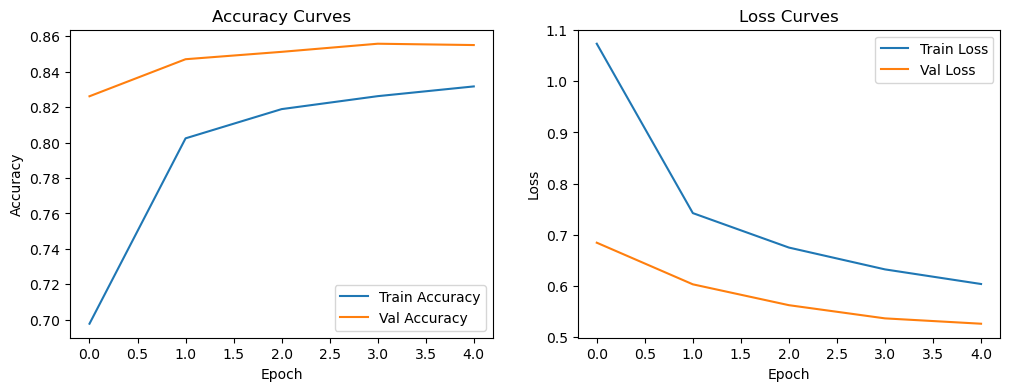

In [12]:
# Plot training curves
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_head.history['accuracy'], label='Train Accuracy')
plt.plot(history_head.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy Curves')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_head.history['loss'], label='Train Loss')
plt.plot(history_head.history['val_loss'], label='Val Loss')
plt.title('Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig('training_curves.png')
plt.show()


In [13]:
# Generate submission
submission_df = pd.DataFrame({'Id': range(len(Y_pred_classes)), 'Label': Y_pred_classes})
submission_df.to_csv('submission.csv', index=False)
print("Submission file saved as submission.csv")

Submission file saved as submission.csv


In [ ]:
plt